In [0]:
#GPU SPECS
!nvidia-smi

Fri Dec 13 06:32:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#importing all the Heavenly creatures.
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras import optimizers
import pandas as pd
from datetime import datetime
import tensorflow as tf

Using TensorFlow backend.


In [0]:
#Loading the data
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


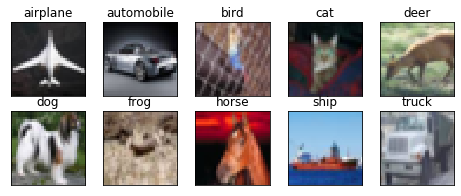

In [0]:
#Plotting images of each category 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot the accuracy and loss curve.
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#function to calculate the accuracy.
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#pixel normalization
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#Function to detect local minimas aiding to find 
#the correct LRs.
def detect_local_minima(arr):
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood) == arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr == 0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

#Functions to find moving averages.
def moving_average_fast(x, w):
    return np.convolve(np.array(x), np.ones(w), 'same') / w


def moving_average(x, w):
    df = pd.DataFrame({"x": x})
    return df.rolling(w, win_type=None, min_periods=1, center=True).mean()['x'].values

#Functions to get the derivatives
def get_derivatives(vals, sma=10):
    assert sma >= 1
    derivatives = [0] * sma
    losses = moving_average(vals, 5)
    for i in range(sma, len(vals)):
        derivatives.append((losses[i] - losses[i - sma]) / sma)
    return derivatives


In [0]:
#class to find the LRs.
class LRFinder:
    #Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.

    def __init__(self, model, num_validation_batches=10):
        self.model = model
        self.losses = []
        self.acc = []
        self.lrs = []
        self.best_loss = 1e9
        self.best_acc = 0
        self.one_minus_acc = []
        self.one_minus_acc_best = []
        self.num_validation_batches = num_validation_batches
        self.validation_set = None
        self.validation_generator = None

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        acc = logs['acc']

        self.losses.append(loss)
        self.acc.append(acc)
        self.one_minus_acc.append(1 - acc)

        # Check whether the loss got too large or NaN
        if batch > 16 and (math.isnan(loss) or loss > self.best_loss * 10):
            self.model.stop_training = True
            print("Stop Training at %s, loss = %.3f" % (batch, loss))
            return

        if loss < self.best_loss:
            self.best_loss = loss
        if acc > self.best_acc:
            self.best_acc = acc

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, train_features, train_labels, start_lr, end_lr,
             test_features=None, test_labels=None,
             batch_size=64, epochs=1):
        num_batches = epochs * train_features.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))
        self.validation_set = (test_features, test_labels) if test_features is not None and test_labels is not None else None
        self.batch_size = batch_size

        self.model.fit(train_features, train_labels,
                       batch_size=batch_size, epochs=epochs,
                       verbose=0,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr,
                       test_generator=None,
                       epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch * epochs))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.validation_generator = test_generator

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 verbose=0,
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=False)

    def plot_one_minus_acc(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=True)

    def __plot__(self, n_skip_beginning=5, n_skip_end=5, sma=10, use_acc=False):

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        y_label = "1 - Acc" if use_acc else "loss"
        plt.ylabel(y_label)
        plt.xlabel("learning rate (log scale)")

        losses = self.losses if not use_acc else self.one_minus_acc
        losses = moving_average(losses, sma)

        losses = losses[n_skip_beginning:-n_skip_end]

        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], losses)
        plt.xscale('log')
        best_lrs = self.get_best_lrs(sma,use_acc=use_acc)
        lrs = [x for x, _ in best_lrs]
        positions = [x for _, x in best_lrs]
        title = "LR vs 1 - Acc Graph" if use_acc else "LR vs Loss Graph"
        plt.title(title)
        plt.show()

    def __get_best_lr_method1__(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        losses = self.losses if not use_acc else self.one_minus_acc
        derivatives = get_derivatives(losses, sma)
        losses = np.array(losses[n_skip_beginning:-n_skip_end])
        derivatives = derivatives[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]

        best_loss = (1 - self.best_acc) if use_acc else self.best_loss
        acceptable_idxs = np.where(losses <= best_loss * 1.75)[0]

        derivatives = derivatives[acceptable_idxs[0]:acceptable_idxs[-1]]

        best_idxs = np.argpartition(derivatives, -5)[-5:]
        best_idxs = best_idxs - sma + acceptable_idxs[0]
        acceptable_loss_or_not = losses[best_idxs] <= best_loss * 1.5
        best_idxs = best_idxs[acceptable_loss_or_not]

        acceptable_loss_or_not = losses[best_idxs + sma] > (losses[best_idxs] * 1.0)
        best_idxs = best_idxs[acceptable_loss_or_not]

        candidates = list(np.array(lrs)[best_idxs])
        return sorted(candidates), best_idxs

    def get_best_lrs(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        c1, i1 = self.__get_best_lr_method1__(sma, n_skip_beginning, n_skip_end, use_acc)
        candidates = list(zip(c1, i1))
        candidates = sorted(candidates, key=lambda pair: pair[0])
        final_candidates = [candidates[0]]
        for v, i in candidates:
            if (v - final_candidates[-1][0]) / final_candidates[-1][0] > 0.2:
                final_candidates.append((v, i))
        final_candidates = list(map(lambda pair: (float("%.3f" % pair[0]), pair[1]), final_candidates))
        print("Final Candidates:- \n",final_candidates)
        return final_candidates

In [0]:
#Function to implement cutout
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True):
    
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)
            input_img[top:top + h, left:left + w, :] = c
        return input_img

    return eraser

In [0]:
import cv2
from keras.preprocessing import image

def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

#return the gradCAM heatmap - gradCAm algorithm
#gradCam function to generate heatmaps
def gradcam(model, layer, img, class_idx, preprocess_func=None, preprocess_img=min_max_scale,
            show=False):
    x = np.expand_dims(image.img_to_array(img), axis=0)
    img = np.copy(img)
    class_idx = np.argmax(class_idx, axis=0) if type(class_idx) == list or type(class_idx) == np.ndarray else class_idx
    if preprocess_func is not None:
        x = preprocess_func(x)
    if preprocess_img is not None:
        img = preprocess_img(img)
    preds = model.predict(x)
    preds = np.argmax(preds, axis=1)[0]

    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)
    layer_out_channels = last_conv_layer.output_shape[-1]

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(layer_out_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = heatmap / 255
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if heatmap[i][j][1] <= 0.01 and heatmap[i][j][2] <= 0.01:
                heatmap[i][j] = 0

    superimposed_img = 0.6 * img + 0.4 * heatmap
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j]) == 0:
                superimposed_img[i][j] = img[i][j]

    superimposed_img = np.clip(superimposed_img, 0, 1, )
    if show:
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        plt.imshow(heatmap)
        plt.axis("off")
        plt.show()
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.show()
    return img, heatmap, superimposed_img, preds

In [0]:
# Define the model
def buildmodel(lr = 0.01):
  model1 = Sequential()
  model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.2))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.3))

  model1.add(Convolution2D(32, 1, 1))


  model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
  model1.add(Activation('relu'))
  model1.add(BatchNormalization())

  model1.add(MaxPooling2D(pool_size=(2, 2)))
  model1.add(Dropout(0.5))

  model1.add(Convolution2D(10, 1, 1))

  model1.add(AveragePooling2D(pool_size = (4,4)))
  model1.add(Flatten())


  model1.add(Activation('softmax'))

  # Compile the model
  sgd = optimizers.SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)
  print("lr:- \n",lr)
  model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  model1.summary()
  return model1

In [0]:
#build the model
model = buildmodel()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`



lr:- 
 0.01




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [0]:
#Add cutouts
cutout_fn = get_cutout_eraser(p=0.50, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True)

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,preprocessing_function=cutout_fn)
datagen.fit(train_features)
datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen_validation.fit(train_features)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Stop Training at 174, loss = 16.912
Final Candidates:- 
 [(0.072, 106), (0.091, 104)]


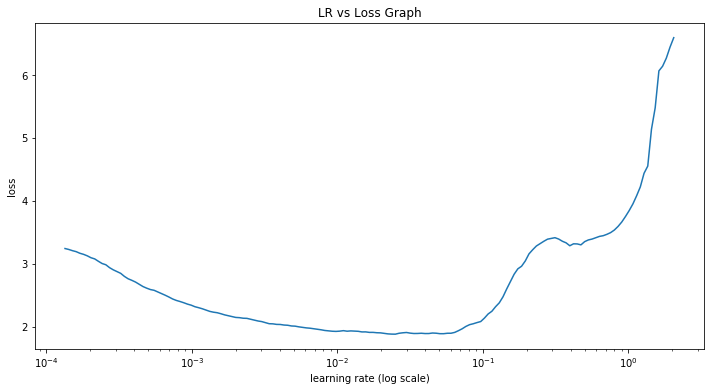

In [0]:
#running the model to get list of LRs
#and plot the curve
lrf = LRFinder(model)
generator = datagen.flow(train_features, train_labels, batch_size=256,shuffle=True)
test_generator = datagen_validation.flow(test_features, test_features, batch_size=256, shuffle=True)
lrf.find_generator(generator, 0.0001, 10.0,test_generator, epochs=1, steps_per_epoch=None,)
lrf.plot_loss(sma=20)

In [0]:
#finding the best learning rate
lr= lrf.get_best_lrs(sma=20)
print("learning rate:- ",lr[-1][0])
#assiging the Lr to a variable
lr = lr[-1][0]

Final Candidates:- 
 [(0.072, 106), (0.091, 104)]
learning rate:-  0.091


## Profiling Using Tensorboard.


In [0]:
#checkpointing the best epoch
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

log_dir="logs/profile/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, profile_batch=3)
callbacks_list=[checkpoint,tensorboard_callback]


#callbacks_list=[checkpoint]

In [0]:
print(train_features.shape[0])
print(train_labels.shape)
train_iterator = datagen.flow(train_features,train_labels , batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(test_features, test_labels, batch_size=512,shuffle=True)
print(len(train_iterator))

50000
(50000, 10)
196


In [0]:
lr = 0.4

In [0]:
#building the model over the obtained learning rate.
model2 = buildmodel(lr)
#start = time.time()
#import cProfile
#Train the model
def train_model():
  model_info = model2.fit_generator(train_iterator,
                        steps_per_epoch=len(train_iterator), 
                        validation_data=(test_features,test_labels), 
                      
                        epochs=1, verbose=1,callbacks=callbacks_list)

#end = time.time()
train_model()
#cProfile.run('train_model()')
#print ("Model took %0.2f seconds to train"%(end - start))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

lr:- 
 0.4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16,

In [0]:
!tar -zcvf logs.tar.gz logs/profile/

logs/profile/
logs/profile/20191213-063316/
logs/profile/20191213-063316/plugins/
logs/profile/20191213-063316/plugins/profile/
logs/profile/20191213-063316/plugins/profile/2019-12-13_06-33-30/
logs/profile/20191213-063316/plugins/profile/2019-12-13_06-33-30/local.trace
logs/profile/20191213-063316/events.out.tfevents.1576218808.a26cad6150c6
logs/profile/20191213-063316/events.out.tfevents.1576218810.a26cad6150c6.profile-empty


# Profiling using CProfile

In [0]:
#building the model over the obtained learning rate.
model3 = buildmodel(lr)
start = time.time()
import cProfile
#Train the model
def train_model():
  model_info = model3.fit_generator(train_iterator,
                        steps_per_epoch=len(train_iterator), 
                        validation_data=(test_features,test_labels), 
                      
                        epochs=1, verbose=1)

end = time.time()
train_model()

print ("Model took %0.2f seconds to train"%(end - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

lr:- 
 0.4
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16,

In [0]:
output = cProfile.run('train_model()','profileResult.prof')

Epoch 1/1
196/196 [==============================] - 10s 50ms/step - loss: 2.9516 - acc: 0.2710 - val_loss: 3.4475 - val_acc: 0.1000


In [0]:
print(output)

None


In [0]:
# plot model history
plot_model_history(model_info)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#function to show all misclassified images
def show_misclassified_with_gradcam(model, layer, iterator, classes=None, preprocess_func=None, preprocess_img=min_max_scale,
                                    image_size_multiplier=3, examples=25,
                                    show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(examples / columns))
    images = []
    labels = []
    predictions = []
    while len(images) < examples:
        batchX, batchY = iterator.next()
        preds = model.predict(batchX)
        X, y_true, y_pred = find_misclassified(batchX, batchY, preds)
        images.extend(X)
        labels.extend(y_true)
        predictions.extend(y_pred)

    images = images[:examples]
    labels = labels[:examples]
    predictions = predictions[:examples]
    show_examples_with_gradcam(model, layer, images, labels, classes=classes, preprocess_func=preprocess_func,
                               preprocess_img=preprocess_img, image_size_multiplier=image_size_multiplier)

In [0]:
#save the model
model2.save("/content/gdrive/My Drive/Assignment17.h5")

# Misclassified Images

In [0]:
import matplotlib.gridspec as gridspec

#function returning all the classes.
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#function to denormalize image so that the images dont bleed.
def denormalize(img):
  return (img*datagen_validation.std + datagen_validation.mean)
  #return img

#function to find misclassified images. if the predicted and 
#actual variable doesnot match then they are misclassified.
def find_misclassified(X, y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    misclassified = y_true != y_pred
    X = X[misclassified]
    y_true = y_true[misclassified]
    y_pred = y_pred[misclassified]
    return X, y_true, y_pred
  

def show_examples_with_gradcam(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=min_max_scale,
                               image_size_multiplier=3,
                               show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    num_inner_rows = int(show_actual + show_heatmap + show_superimposed)
    labels = np.argmax(labels, axis=1) if type(labels[0]) == list or type(labels[0]) == np.ndarray else labels
    fig_height = rows * image_size_multiplier * num_inner_rows
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows * columns):
        if i >= len(images):
            break
        x = images[i]
        y = labels[i]
        img, heatmap, superimposed_img, prediction = gradcam(model, layer, x, y, preprocess_func=preprocess_func,
                                                             preprocess_img=preprocess_img, show=False)
        inner = gridspec.GridSpecFromSubplotSpec(num_inner_rows, 1,
                                                 subplot_spec=outer[i], wspace=0.0, hspace=0.05)

        imgs = []
        if show_actual:
            imgs.append(img)
        if show_heatmap:
            imgs.append(heatmap)
        if show_superimposed:
            imgs.append(superimposed_img)
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:" + label + " Pred:" + prediction).replace(' ', '\n')]
        for j in range(num_inner_rows):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles.pop() if len(titles) > 0 else "")
            fig.add_subplot(ax)

    fig.show()



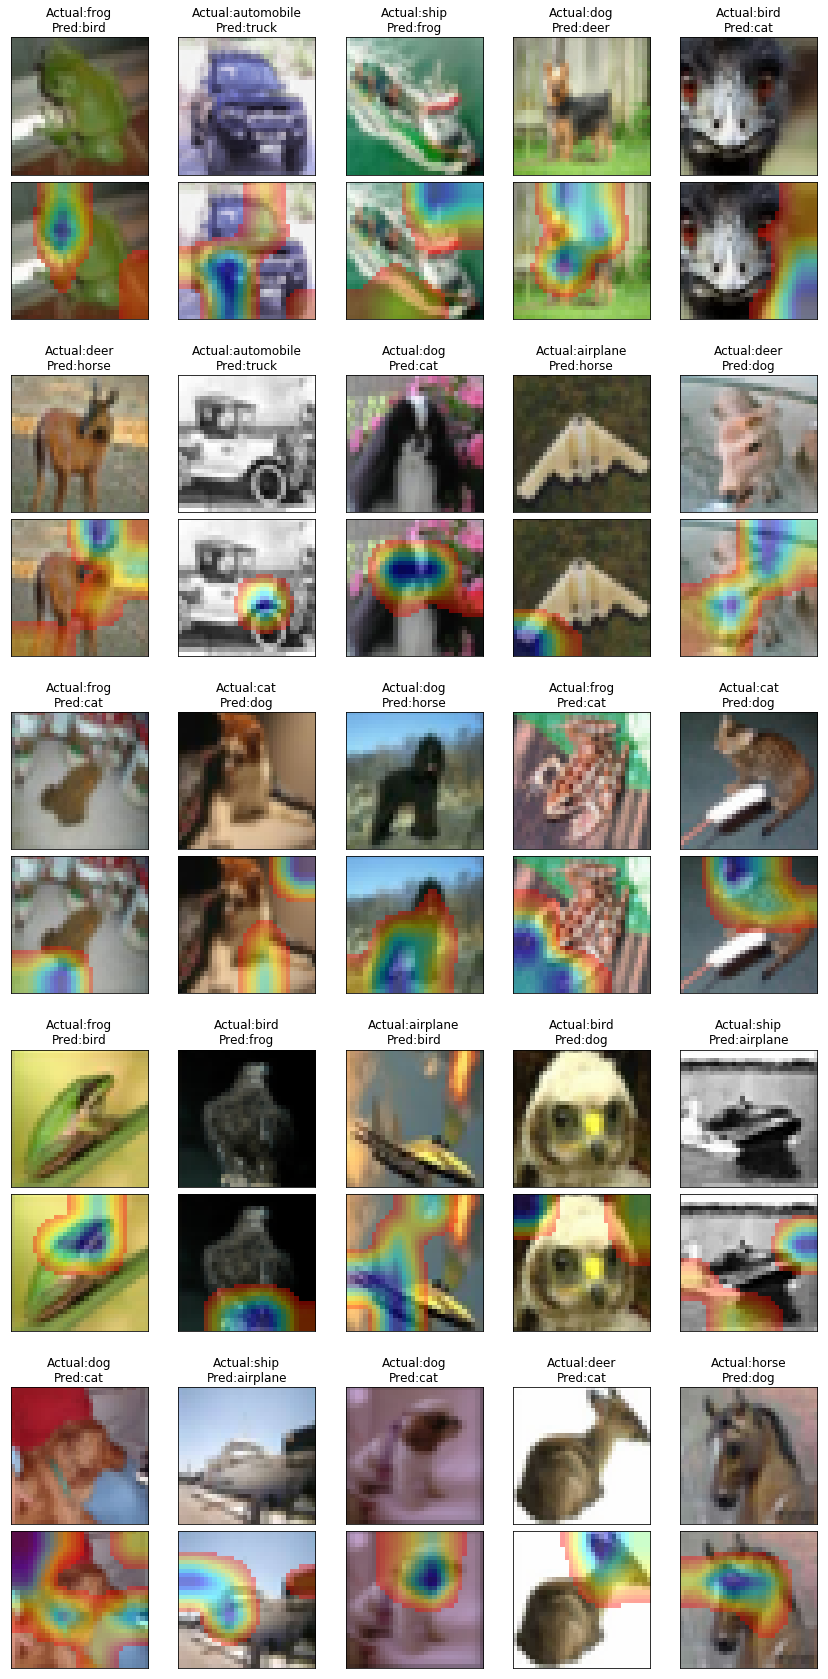

In [0]:
#displaying the misclassified Images
iterator = datagen_validation.flow(test_features, test_labels, batch_size=256, shuffle=False)
show_misclassified_with_gradcam(model2,"conv2d_18",iterator,classes=get_cifar10_labels(),preprocess_func=None,image_size_multiplier=3, examples=25,preprocess_img=denormalize)